In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
from sunRay.parameters import c,c_r,R_S  # physics parameters
from scipy import integrate

import multiprocessing as mp
from matplotlib import rc
import sunRay.statisticalRays as raystat
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

In [2]:

%load_ext autoreload
%autoreload 2

In [3]:

data_fnames = ['RUN_[eps0.102]_[alpha0.15743].lv1.npz',
              'RUN_[eps0.354]_[alpha0.15743].lv1.npz',
              'RUN_[eps0.102]_[alpha0.802].lv1.npz',
              'RUN_[eps0.354]_[alpha0.802].lv1.npz']

#data_set  = np.load('../RUN3/funda/RUN_[eps0.27]_[alpha0.72143].lv1.npz')

data_set  = np.load('../RUN3/funda/RUN_[eps0.282]_[alpha0.72143].lv1.npz')
#data_set  = np.load('../RUN3/funda/RUN_[eps0.27]_[alpha0.614].lv1.npz')


#data_set  = np.load('../RUN3/f105/RUN_[eps0.354]_[alpha0.15743].lv1.npz')

#

In [5]:
#dir(data_set.f)

In [39]:
for fnum in [0,1,2,3]:
    offset_x=[]

    offset_err=[]

    import warnings
    warnings.filterwarnings("ignore")

    ang_rot_set = np.arcsin(np.linspace(0,1,100))*180/np.pi
    ang_rot_set = np.linspace(0,90,100)

    for pat in ['funda','harmo']:
        # collect the data

        data_set  = np.load('../tmpRUN/'+pat+'/'+data_fnames[fnum])

        anis  = data_set.f.anis
        asym  = data_set.f.asym
        collect_N  = data_set.f.collect_N
        epsilon  = data_set.f.epsilon
        f_ratio  = data_set.f.f_ratio
        freq0  = data_set.f.freq0
        k_vec_0  = data_set.f.k_vec_0
        k_vec_stat_avail  = data_set.f.k_vec_stat_avail
        omega0  = data_set.f.omega0
        photon_N  = data_set.f.photon_N
        r_vec_0  = data_set.f.r_vec_0
        r_vec_stat_avail  = data_set.f.r_vec_stat_avail
        start_phi  = data_set.f.start_phi
        start_r  = data_set.f.start_r
        start_theta  = data_set.f.start_theta
        steps_N  = data_set.f.steps_N
        t_reach_stat_avail  = data_set.f.t_reach_stat_avail
        tau_stat_avail  = data_set.f.tau_stat_avail

        def rotationCollect(ang_rot,r_vec_stat_avail=r_vec_stat_avail,
                           k_vec_stat_avail=k_vec_stat_avail,
                           r_vec_0=r_vec_0,k_vec_0=k_vec_0,
                           t_reach_stat_avail=t_reach_stat_avail,
                           tau_stat_avail=tau_stat_avail):

            r_vec_rot,k_vec_rot = raystat.rotateCoordKX(
                r_vec_stat_avail,k_vec_stat_avail,-ang_rot*np.pi/180)
            r_vec0_rot,k_vec0_rot = raystat.rotateCoordKX(
                r_vec_0,k_vec_0,-ang_rot*np.pi/180)

            (x_im_stat,y_im_stat,t_reach_1au_stat,weights_stat,t_free_stat,idx_for_stat
                )=raystat.ImgXYtEstimate(r_vec_rot,k_vec_rot,t_reach_stat_avail,
                        tau_stat_avail,r_vec0_rot, k_vec0_rot,num_t_bins=60)

            x_0,y_0=np.mean(r_vec0_rot,axis=1)[0:2]

            (xc,yc,sx,sy,
             err_xc,err_yc,err_sx,err_sy) = raystat.centroidXYFWHM(
                        x_im_stat,y_im_stat,weights_stat)
            return xc-x_0,err_xc

        pool = mp.Pool(processes=50)

        result = pool.map( rotationCollect , ang_rot_set)

        offset_x.append(np.array([x[0] for x in result ]))
        offset_err.append(np.array([x[1] for x in result ]))
        
        pool.close()
        pool.join()


    fig = plt.figure(figsize=[4.3,3.3])
    ax = plt.gca()
    
    ax.set_position([0.18,0.125,0.78,0.78])
    l1=ax.errorbar(np.sin(ang_rot_set/180*np.pi),offset_x[0],offset_err[0],color='c',
                     drawstyle='steps-mid',capsize=1,elinewidth=0.2,linewidth=0.6)
    l2=ax.errorbar(np.sin(ang_rot_set/180*np.pi),offset_x[1],offset_err[1],color='m',
                     drawstyle='steps-mid',capsize=1,elinewidth=0.2,linewidth=0.6)

    #l3=ax.plot(np.sin(ang_rot_set/180*np.pi),
    #               offset_x[1]+np.sin(ang_rot_set/180*np.pi)*(2.10428659-1.75),
    #               color='k',linewidth=1.0)

    
    
    ax.tick_params(direction='in')
    ax.set_xlim([0,1])
    ax.set_ylabel(r'Offset Outward $R_s$')
    ax.set_xlabel(r'$\sin\theta_0$')

    ax.set_title(r'$\epsilon='+str(np.round(epsilon,3))+r'\quad \alpha='+
                      str(np.round(anis,3))+'$')

    ax.legend((l1, l2, l3), (r'$f_0/f_{pe}=1.1$', r'$f_0/f_{pe}=2.0$'))

    fig.savefig('img/'+'offset_angrot_e'+str(np.round(epsilon,3))+'a'+str(np.round(anis,3))+'.pdf')
    
    plt.close(fig)
    
    
    
    fig = plt.figure(figsize=[4.3,3.3])
    ax = plt.gca()
    
    ax.set_position([0.18,0.125,0.78,0.78])
    l1,=ax.plot(np.sin(ang_rot_set/180*np.pi),
                   (2.10428659-1.75)*np.sin(ang_rot_set/180*np.pi)+offset_x[1]-offset_x[0],
               color='r',linewidth=1)
    l2,=ax.plot(np.sin(ang_rot_set/180*np.pi),
                   (2.10428659-1.75)*np.sin(ang_rot_set/180*np.pi),color='k',
                     linewidth=1)

    #l3=ax.plot(np.sin(ang_rot_set/180*np.pi),
    #               offset_x[1]+np.sin(ang_rot_set/180*np.pi)*(2.10428659-1.75),
    #               color='k',linewidth=1.0)

    
    
    ax.tick_params(direction='in')
    ax.set_xlim([0,1])
    ax.set_ylabel(r'Offset Outward $R_s$')
    ax.set_xlabel(r'$\sin\theta_0$')

    ax.set_title(r'$\epsilon='+str(np.round(epsilon,3))+r'\quad \alpha='+
                      str(np.round(anis,3))+'$')

    ax.legend((l1, l2), (r'$x_{\mathrm{H}}-x_{\mathrm{F}}$', r'$\Delta R\sin\theta_0$'))

    fig.savefig('img/'+'offset_delta_e'+str(np.round(epsilon,3))+'a'+str(np.round(anis,3))+'.pdf')
    
    plt.close(fig)
    

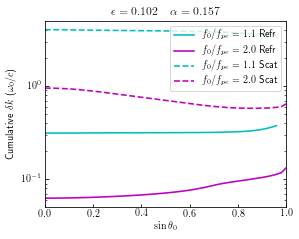

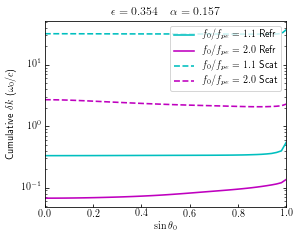

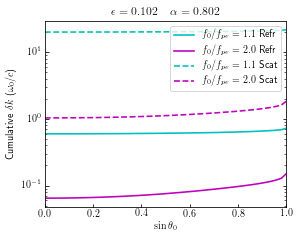

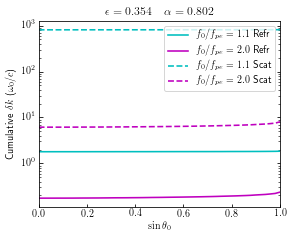

In [11]:
# for all params
pat='funda'


for fnum in [0,1,2,3]:
    offset_refr=[]

    offset_scat=[]

    import warnings
    warnings.filterwarnings("ignore")

    ang_rot_set = np.arcsin(np.linspace(0,1,50))*180/np.pi
    #ang_rot_set = np.linspace(0,90,100)

    for pat in ['funda','harmo']:
        # collect the data

        data_set  = np.load('../tmpRUN/'+pat+'/'+data_fnames[fnum])

        anis  = data_set.f.anis
        asym  = data_set.f.asym
        collect_N  = data_set.f.collect_N
        epsilon  = data_set.f.epsilon
        f_ratio  = data_set.f.f_ratio
        freq0  = data_set.f.freq0
        k_vec_0  = data_set.f.k_vec_0
        k_vec_stat_avail  = data_set.f.k_vec_stat_avail
        omega0  = data_set.f.omega0
        photon_N  = data_set.f.photon_N
        r_vec_0  = data_set.f.r_vec_0
        r_vec_stat_avail  = data_set.f.r_vec_stat_avail
        start_phi  = data_set.f.start_phi
        start_r  = data_set.f.start_r
        start_theta  = data_set.f.start_theta
        steps_N  = data_set.f.steps_N
        t_reach_stat_avail  = data_set.f.t_reach_stat_avail
        tau_stat_avail  = data_set.f.tau_stat_avail
        dk_refr_avail = data_set.f.dk_refr_avail
        dk_scat_avail = data_set.f.dk_scat_avail

        def rotationCollect(ang_rot,r_vec_stat_avail=r_vec_stat_avail,
                           k_vec_stat_avail=k_vec_stat_avail,
                           r_vec_0=r_vec_0,k_vec_0=k_vec_0,
                           t_reach_stat_avail=t_reach_stat_avail,
                           tau_stat_avail=tau_stat_avail):

            r_vec_rot,k_vec_rot = raystat.rotateCoordKX(
                r_vec_stat_avail,k_vec_stat_avail,-ang_rot*np.pi/180)
            r_vec0_rot,k_vec0_rot = raystat.rotateCoordKX(
                r_vec_0,k_vec_0,-ang_rot*np.pi/180)

            kk_stat_avail = np.sqrt(np.sum(k_vec_rot**2,axis=0))
            kz_stat_avail = k_vec_rot[2,:]

            idx_for_stat = np.where((kz_stat_avail/kk_stat_avail<1.00) & 
                            (kz_stat_avail/kk_stat_avail>0.90))
            
            
            refr_res = np.mean((dk_refr_avail)[idx_for_stat])
            scat_res = np.mean((dk_scat_avail)[idx_for_stat])
            return (refr_res,scat_res)

        pool = mp.Pool(processes=50)

        result = pool.map( rotationCollect , ang_rot_set)

        offset_refr.append(np.array([x[0] for x in result ])) # wrong
        offset_scat.append(np.array([x[1] for x in result ])) # wrong
        pool.close()
        pool.join()


    fig = plt.figure(figsize=[4.3,3.3])
    ax = plt.gca()
    
    ax.set_yscale('log')
    ax.yaxis.set_ticks_position('both')
    
    ax.set_position([0.18,0.125,0.78,0.78])
    l1,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_refr[0],color='c',
                     linewidth=1.6)
    l2,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_refr[1],color='m',
                     linewidth=1.6)

    
    l11,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_scat[0],color='c',
                     linewidth=1.6, linestyle='dashed')
    l21,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_scat[1],color='m',
                     linewidth=1.6, linestyle='dashed')
    
    ax.tick_params(direction='in', which='both')
    ax.set_xlim([0,1])
    ax.set_ylabel(r'Cumulative $\delta k$ ($\omega_0/c$)')
    ax.set_xlabel(r'$\sin\theta_0$')

    ax.set_title(r'$\epsilon='+str(np.round(epsilon,3))+r'\quad \alpha='+
                      str(np.round(anis,3))+'$')

    ax.legend((l1, l2,l11,l21), (r'$f_0/f_{pe}=1.1$ Refr', r'$f_0/f_{pe}=2.0$ Refr',
                                r'$f_0/f_{pe}=1.1$ Scat', r'$f_0/f_{pe}=2.0$ Scat'))
    #ax.legend((l1, l2), (r'a', r'b'))
    fig.savefig('img/'+'offset_inte_e'+str(np.round(epsilon,3))+'a'+str(np.round(anis,3))+'.pdf')

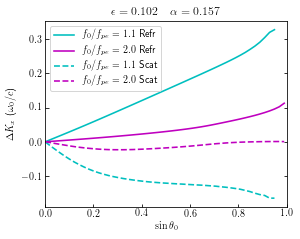

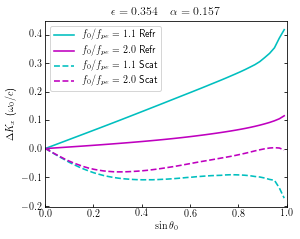

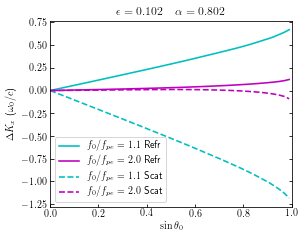

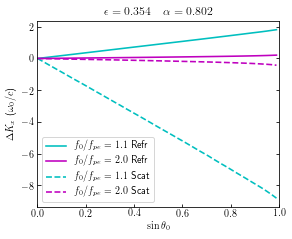

In [51]:
# for all params
pat='funda'


for fnum in [0,1,2,3]:
    offset_refr=[]

    offset_scat=[]

    import warnings
    warnings.filterwarnings("ignore")

    ang_rot_set = np.arcsin(np.linspace(0,0.99,50))*180/np.pi
   # ang_rot_set = np.linspace(0,90,100)

    for pat in ['funda','harmo']:
        # collect the data

        data_set  = np.load('../tmpRUNvec/'+pat+'/'+data_fnames[fnum])

        anis  = data_set.f.anis
        asym  = data_set.f.asym
        collect_N  = data_set.f.collect_N
        epsilon  = data_set.f.epsilon
        f_ratio  = data_set.f.f_ratio
        freq0  = data_set.f.freq0
        k_vec_0  = data_set.f.k_vec_0
        k_vec_stat_avail  = data_set.f.k_vec_stat_avail
        omega0  = data_set.f.omega0
        photon_N  = data_set.f.photon_N
        r_vec_0  = data_set.f.r_vec_0
        r_vec_stat_avail  = data_set.f.r_vec_stat_avail
        start_phi  = data_set.f.start_phi
        start_r  = data_set.f.start_r
        start_theta  = data_set.f.start_theta
        steps_N  = data_set.f.steps_N
        t_reach_stat_avail  = data_set.f.t_reach_stat_avail
        tau_stat_avail  = data_set.f.tau_stat_avail
        dk_refr_avail = data_set.f.dk_refr_avail
        dk_scat_avail = data_set.f.dk_scat_avail
        
        dkx_refr_avail = data_set.f.dkx_refr_avail
        dky_refr_avail = data_set.f.dky_refr_avail
        dkz_refr_avail = data_set.f.dkz_refr_avail
        
        dkx_scat_avail = data_set.f.dkx_scat_avail
        dky_scat_avail = data_set.f.dky_scat_avail
        dkz_scat_avail = data_set.f.dkz_scat_avail
        
        dk_arr_refr = np.stack((dkx_refr_avail,dky_refr_avail,dkz_refr_avail),0)
        dk_arr_scat = np.stack((dkx_scat_avail,dky_scat_avail,dkz_scat_avail),0)
        
        dkk_refr = np.sqrt(dkx_refr_avail**2+dky_refr_avail**2+dkz_refr_avail**2)
        dkk_scat = np.sqrt(dkx_scat_avail**2+dky_scat_avail**2+dkz_scat_avail**2)

        def rotationCollect(ang_rot,r_vec_stat_avail=r_vec_stat_avail,
                           k_vec_stat_avail=k_vec_stat_avail,
                           r_vec_0=r_vec_0,k_vec_0=k_vec_0,
                           t_reach_stat_avail=t_reach_stat_avail,
                           tau_stat_avail=tau_stat_avail):

            r_vec_rot,k_vec_rot = raystat.rotateCoordKX(
                r_vec_stat_avail,k_vec_stat_avail,-ang_rot*np.pi/180)
            dk_arr_refr_rot,dk_arr_scat_rot = raystat.rotateCoordKX(
                dk_arr_refr,dk_arr_scat,-ang_rot*np.pi/180)
            r_vec0_rot,k_vec0_rot = raystat.rotateCoordKX(
                r_vec_0,k_vec_0,-ang_rot*np.pi/180)

            kk_stat_avail = np.sqrt(np.sum(k_vec_rot**2,axis=0))
            kz_stat_avail = k_vec_rot[2,:]

            idx_for_stat = np.where((kz_stat_avail/kk_stat_avail<1.00) & 
                            (kz_stat_avail/kk_stat_avail>0.90))
            
            #refr_res = np.average((dkk_refr)[idx_for_stat])
            #scat_res = np.average((dkk_scat)[idx_for_stat])
            #refr_res = np.average(np.sqrt(dk_arr_refr_rot[0,idx_for_stat]**2 
            #                             +dk_arr_refr_rot[1,idx_for_stat]**2 ))
            #scat_res = np.average(np.sqrt(dk_arr_scat_rot[0,idx_for_stat]**2 
            #                             +dk_arr_scat_rot[1,idx_for_stat]**2 ))
            
            refr_res = np.average((dk_arr_refr_rot[0,idx_for_stat]))
            scat_res = np.average((dk_arr_scat_rot[0,idx_for_stat]))
 
            return (refr_res,scat_res)

        pool = mp.Pool(processes=50)

        result = pool.map( rotationCollect , ang_rot_set)

        offset_refr.append(np.array([-x[0] for x in result ]))
        offset_scat.append(np.array([x[1] for x in result ])) 
        pool.close()
        pool.join()


    fig = plt.figure(figsize=[4.3,3.3])
    ax = plt.gca()
    
    #ax.set_yscale('log')
    ax.yaxis.set_ticks_position('both')
    
    ax.set_position([0.18,0.125,0.78,0.78])
    l1,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_refr[0],color='c',
                     linewidth=1.6)
    l2,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_refr[1],color='m',
                     linewidth=1.6)

    
    l11,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_scat[0],color='c',
                     linewidth=1.6, linestyle='dashed')
    l21,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_scat[1],color='m',
                     linewidth=1.6, linestyle='dashed')
    
    ax.tick_params(direction='in', which='both')
    ax.set_xlim([0,1])
    ax.set_ylabel(r'$\Delta K_x$ ($\omega_0/c$)')
    ax.set_xlabel(r'$\sin\theta_0$')

    ax.set_title(r'$\epsilon='+str(np.round(epsilon,3))+r'\quad \alpha='+
                      str(np.round(anis,3))+'$')

    ax.legend((l1, l2,l11,l21), (r'$f_0/f_{pe}=1.1$ Refr', r'$f_0/f_{pe}=2.0$ Refr',
                                r'$f_0/f_{pe}=1.1$ Scat', r'$f_0/f_{pe}=2.0$ Scat'))
    #ax.legend((l1, l2), (r'a', r'b'))
    fig.savefig('img/'+'offset_inte_vec_e'+str(np.round(epsilon,3))+'a'+str(np.round(anis,3))+'.pdf')

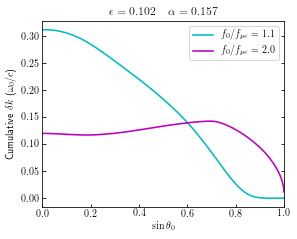

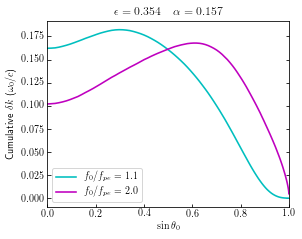

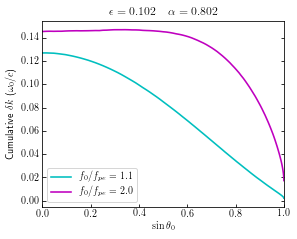

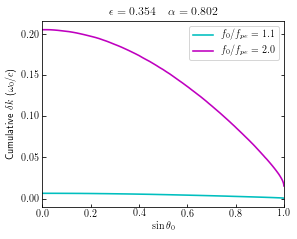

In [13]:
# for all params
pat='funda'


for fnum in [0,1,2,3]:
    offset_refr=[]

    offset_flux=[]

    import warnings
    warnings.filterwarnings("ignore")

    ang_rot_set = np.arcsin(np.linspace(0,1,100))*180/np.pi
    ang_rot_set = np.linspace(0,90,100)

    for pat in ['funda','harmo']:
        # collect the data

        data_set  = np.load('../tmpRUN/'+pat+'/'+data_fnames[fnum])

        anis  = data_set.f.anis
        asym  = data_set.f.asym
        collect_N  = data_set.f.collect_N
        epsilon  = data_set.f.epsilon
        f_ratio  = data_set.f.f_ratio
        freq0  = data_set.f.freq0
        k_vec_0  = data_set.f.k_vec_0
        k_vec_stat_avail  = data_set.f.k_vec_stat_avail
        omega0  = data_set.f.omega0
        photon_N  = data_set.f.photon_N
        r_vec_0  = data_set.f.r_vec_0
        r_vec_stat_avail  = data_set.f.r_vec_stat_avail
        start_phi  = data_set.f.start_phi
        start_r  = data_set.f.start_r
        start_theta  = data_set.f.start_theta
        steps_N  = data_set.f.steps_N
        t_reach_stat_avail  = data_set.f.t_reach_stat_avail
        tau_stat_avail  = data_set.f.tau_stat_avail
        dk_refr_avail = data_set.f.dk_refr_avail
        dk_scat_avail = data_set.f.dk_scat_avail

        def rotationCollect(ang_rot,r_vec_stat_avail=r_vec_stat_avail,
                           k_vec_stat_avail=k_vec_stat_avail,
                           r_vec_0=r_vec_0,k_vec_0=k_vec_0,
                           t_reach_stat_avail=t_reach_stat_avail,
                           tau_stat_avail=tau_stat_avail):

            r_vec_rot,k_vec_rot = raystat.rotateCoordKX(
                r_vec_stat_avail,k_vec_stat_avail,-ang_rot*np.pi/180)
            r_vec0_rot,k_vec0_rot = raystat.rotateCoordKX(
                r_vec_0,k_vec_0,-ang_rot*np.pi/180)

            kk_stat_avail = np.sqrt(np.sum(k_vec_rot**2,axis=0))
            kz_stat_avail = k_vec_rot[2,:]

            idx_for_stat = np.where((kz_stat_avail/kk_stat_avail<1.00) & 
                            (kz_stat_avail/kk_stat_avail>0.90))
            
            
            flux = np.sum((np.exp(-tau_stat_avail))[idx_for_stat])/1e6
            
            return (flux,flux)

        pool = mp.Pool(processes=50)

        result = pool.map( rotationCollect , ang_rot_set)

        offset_flux.append(np.array([x[0] for x in result ])) # wrong
        pool.close()
        pool.join()


    fig = plt.figure(figsize=[4.3,3.3])
    ax = plt.gca()
    
    #ax.set_yscale('log')
    ax.yaxis.set_ticks_position('both')
    
    ax.set_position([0.18,0.125,0.78,0.78])
    l1,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_flux[0],color='c',
                     linewidth=1.6)
    l2,=ax.plot(np.sin(ang_rot_set/180*np.pi),offset_flux[1],color='m',
                     linewidth=1.6)

    
    ax.tick_params(direction='in', which='both')
    ax.set_xlim([0,1])
    ax.set_ylabel(r'Cumulative $\delta k$ ($\omega_0/c$)')
    ax.set_xlabel(r'$\sin\theta_0$')

    ax.set_title(r'$\epsilon='+str(np.round(epsilon,3))+r'\quad \alpha='+
                      str(np.round(anis,3))+'$')

    ax.legend((l1, l2), (r'$f_0/f_{pe}=1.1$', r'$f_0/f_{pe}=2.0$'))
    #ax.legend((l1, l2), (r'a', r'b'))
    fig.savefig('img/'+'offset_flux_'+str(np.round(epsilon,3))+'a'+str(np.round(anis,3))+'.pdf')

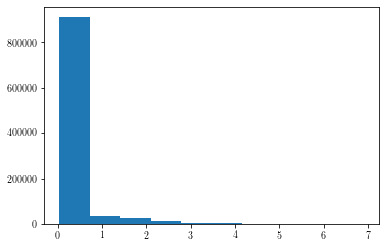

In [14]:
hst = plt.hist(tau_stat_avail)

In [12]:
tau_stat_avail.shape

(996943,)

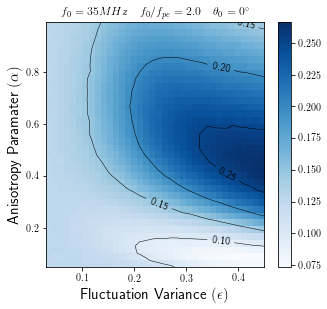

In [25]:
angrotstr='0'

import numpy as np
data_par  = np.load('parsetRUN3.harmo.rot'+angrotstr+'.v1.npz')

res = (data_par.f.arr_0)

arr_eps   = np.linspace(0.03,0.45,36)    
arr_alpha = np.linspace(0.05,0.99,36)


from scipy.ndimage.filters import gaussian_filter
sigma=0.4
#data = gaussian_filter(data, sigma)

plt.figure(figsize=[5,4.5])

plt.imshow(res[15].T,origin='lower',
           extent=[np.min(arr_eps),np.max(arr_eps),np.min(arr_alpha),np.max(arr_alpha)],
          cmap='Blues')#,vmax=7,vmin=0)
cbar = plt.colorbar()
#cbar.ax.set_title('Offset $R_s$')

ax = plt.gca()

CS = ax.contour(arr_eps,arr_alpha,gaussian_filter(res[15].T,sigma),[0.1,0.15,0.2,0.25],colors=['k'],linewidths =0.5)
ax.clabel(CS,  CS.levels,  inline=True,  fontsize=10,fmt=r'%1.2f')

ax.set_xlabel(r'Fluctuation Variance $(\epsilon)$',fontsize=15)
ax.set_ylabel(r'Anisotropy Paramater $(\alpha)$',fontsize=15)

ax.set_aspect(1/2)
ax.set_title(r'$f_0=35MHz \quad f_0/f_{pe}=2.0\quad \theta _0='+angrotstr+'^{\circ}$')
fig = plt.gcf()

fig.savefig('img/flux_harmo'+angrotstr+'.pdf')



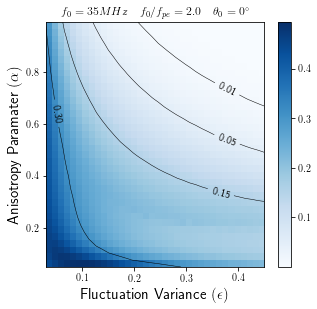

In [23]:
import numpy as np
data_par  = np.load('parsetRUN3.funda.rot'+angrotstr+'.v1.npz')
res = data_par.f

res = (data_par.f.arr_0)

arr_eps   = np.linspace(0.03,0.45,36)    
arr_alpha = np.linspace(0.05,0.99,36)


from scipy.ndimage.filters import gaussian_filter
sigma=0.3
#data = gaussian_filter(data, sigma)

plt.figure(figsize=[5,4.5])

plt.imshow(res[15].T,origin='lower',
           extent=[np.min(arr_eps),np.max(arr_eps),np.min(arr_alpha),np.max(arr_alpha)],
          cmap='Blues')#,vmax=7,vmin=0)
cbar = plt.colorbar()
#cbar.ax.set_title('Offset $R_s$')

ax = plt.gca()

CS = ax.contour(arr_eps,arr_alpha,gaussian_filter(res[15].T,sigma),[0.01,0.05,0.15,0.3],colors=['k'],linewidths =0.5)
ax.clabel(CS,  CS.levels,  inline=True,  fontsize=10,fmt=r'%1.2f')

ax.set_xlabel(r'Fluctuation Variance $(\epsilon)$',fontsize=15)
ax.set_ylabel(r'Anisotropy Paramater $(\alpha)$',fontsize=15)

ax.set_aspect(1/2)
ax.set_title(r'$f_0=35MHz \quad f_0/f_{pe}=2.0\quad \theta _0='+angrotstr+'^{\circ}$')
fig = plt.gcf()


fig.savefig('img/flux_funda'+angrotstr+'.pdf')

In [32]:
from sunRay import tool

import sunRay.densityModel as dm  

In [27]:
tool.R_to_freq(10,1)/1e6

tensor([0.7612])

In [38]:
tool.freq_to_R(60e6,1.1,dm.newkirk)

array([1.4651196])